# CGAN(Conditional GAN) : 일반적인 GAN은 특정 레이블의 특징을 갖는 이미지만을 따로 생성하지 못함
* CGAN은 생성자가 레이블에 맞는 이미지를 생성함으로써 판별자에게 전달함
* 판별자는 (생성자가만든 가짜 이미지, 레이블) 쌍과 (진짜 이미지, 레이블) 쌍을 받아 진짜일 확률을 sigmoid함수로 출력함
* 생성자는 판별자를 속이기 위해 레이블에 맞는 이미지를 최대한 출력해야 함

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense, Embedding, Flatten,
                                     Input, Multiply, Reshape, LeakyReLU, Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

In [3]:
# CGAN 생성자
# 일반적인 CGAN과 다른 부분은 입력처리 부분 --> Embedding과 원소별 곱셈을 사용해 Random Noise Vector z와 레이블 y를 하나의 표현으로 합침

def build_generator(z_dim):
    '''
    일반적인 generator 모델
    '''

    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))   # (14,14,128)
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))    # (14,14,64)
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))


    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))   # (28,28,1)
    model.add(Activation('tanh'))

    return model


def build_cgan_generator(z_dim):
  '''
  # 1. 레이블 y(0~9)를 받아 keras embedding 층으로 z_dim크기의 밀집 벡터로 변환
  # 2. Keras Multiply 층으로 레이블 임베딩과 Noise Vector Z를 합침. 동일한 길이 2개의 벡터의 각 원소를 곱해 결과로 이뤄진 하나의 벡터를 출력
  '''

  z = Input(shape=(z_dim, ))  # noise vector z
  label = Input(shape=(1, ), dtype='int32')  # 조건 레이블 : 정수 0~9까지 생성자가 만들 숫자

  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label) # label_embedding --> 레이블을 z_dim크기 밀집 벡터로 변환 후 (batch_size, 1, z_dim)크기의 텐서 생성
  label_embedding = Flatten()(label_embedding) # embedding된 3d텐서를 펼쳐 2D텐서로 만듦
  
  joined_representation = Multiply()([z, label_embedding])  # z와 레이블 임베딩의 원소별 곱셈

  generator = build_generator(z_dim)

  conditioned_img = generator(joined_representation)

  return Model([z, label], conditioned_img)


# CGAN 판별자
# 해당 판별자에서도 Keras Embedding층을 활용해 입력 레이블을 밀집 벡터로 변환
# 판별자는 입력으로 3차원 이미지를 받기 때문에 관련 처리 필요

def build_discriminator(img_shape):

    model = Sequential()
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),    # (28,28,2) --> (14,14,64)
               padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,             # (7,7,64)
               padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,            # (3,3,128)
               padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


def build_cgan_discriminator(img_shape):
    '''
    1. 정수 레이블(0~9)을 받아 Keras Embedding 층으로 이미지를 펼친 길이인 28*28*1 = 784 크기의 밀집 벡터로 변환
    2. 레이블 임베딩을 이미지 차원(28*28*1)으로 바꿈
    3. 크기를 바꾼 레이블 임베딩을 상응하는 이미지와 연결하여 (28*28*2)크기의 표현으로 함침
    (이미지 위에 임베딩된 레이블로 도장을 찍는 느낌...)
    4. 이미지-레이블 조인트 표현을 CGAN 판별자 네트워크의 입력으로 주입. 새 입력크기에 맞게 모델의 입력차원을 28*28*2로 조정
    '''

    img = Input(shape=img_shape)     # img
    label = Input(shape=(1, ), dtype='int32')   # label
    
    label_embedding = Embedding(num_classes,
                                np.prod(img_shape),
                                input_length=1)(label)   # label_embedding : 레이블을 z_dim크기의 밀집벡터로 변환하고 (batch_size, 1, 28*28*1) 크기 텐서로 변환
  
    label_embedding = Flatten()(label_embedding)  # label_embedding(3D Tensor)를 펼쳐 (batch_size, 28*28*1) 크기 2D Tensor로 변환
    label_embedding = Reshape(img_shape)(label_embedding) # (batch_size, 28*28*1) --> (28, 28, 1)


    concatenated = Concatenate(axis=-1)([img, label_embedding]) # img + label_embedding --> (28, 28, 2)

    discriminator = build_discriminator(img_shape)

    classification = discriminator(concatenated)

    return Model([img, label], classification)

# CGAN 모델생성

def build_cgan(generator, discriminator):

  z = Input(shape=(z_dim, ))   # noise vector z
  label = Input(shape=(1, ))

  img = generator([z, label])  # generator에서 레이블에 맞는 이미지 생성
  classification = discriminator([img, label])

  model = Model([z, label], classification)
  
  return model



discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001),
                      metrics=['accuracy'])

generator = build_cgan_generator(z_dim)
discriminator.trainable = False

cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [4]:
# CGAN Training

accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):

  (X_train, y_train), (_, _) = mnist.load_data()
  X_train = X_train / 127.5 - 1
  X_train = np.expand_dims(X_train, axis=3)

  real = np.ones((batch_size, 1))   # 진짜 이미지의 레이블(전부 1)
  fake = np.zeros((batch_size, 1))  # 가짜 이미지릐 레이블(전부 0)

  for iteration in range(iterations):

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels])
    
    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0,1, (batch_size, z_dim))   # noise vector의 배치 생성

    labels = np.random.randint(0, num_classes, batch_size).reshape(-1,1)  # random한 레이블의 배치를 얻음

    g_loss = cgan.train_on_batch([z,labels], real)   # 생성자를 훈련
    
    if (iteration + 1) % sample_interval == 0:

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
            (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # Output sample of generated images
      sample_images()

In [5]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
    '''
    이전 sample_images 함수와 다른 점 --> 1열에 1~5의 레이블(숫자)이 들어가고
                                      2열에 6~10의 레이블(숫자)가 들어감
    '''

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    labels = np.arange(0, 10).reshape(-1, 1)

    # Generate images from random noise
    gen_imgs = generator.predict([z, labels])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

1000 [D loss: 0.750570, acc.: 43.75%] [G loss: 0.015031]
2000 [D loss: 0.114257, acc.: 100.00%] [G loss: 0.034436]
3000 [D loss: 0.019067, acc.: 100.00%] [G loss: 0.026973]
4000 [D loss: 0.003655, acc.: 100.00%] [G loss: 0.025178]
5000 [D loss: 0.000903, acc.: 100.00%] [G loss: 0.027980]
6000 [D loss: 0.000389, acc.: 100.00%] [G loss: 0.045023]
7000 [D loss: 0.000159, acc.: 100.00%] [G loss: 0.075644]
8000 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.106859]
9000 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.108198]
10000 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.129285]
11000 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.263638]
12000 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.604651]
13000 [D loss: 0.236160, acc.: 92.19%] [G loss: 0.013773]
14000 [D loss: 0.005785, acc.: 100.00%] [G loss: 0.035044]
15000 [D loss: 0.000706, acc.: 100.00%] [G loss: 0.016063]
16000 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.011397]
17000 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.016661]
18000 [D

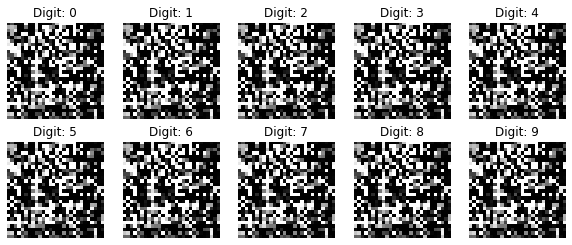

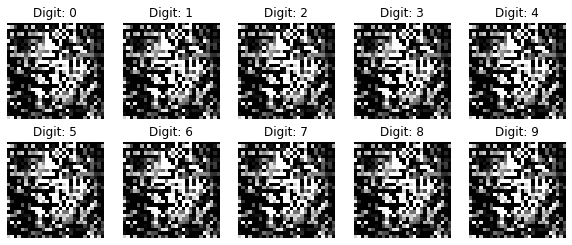

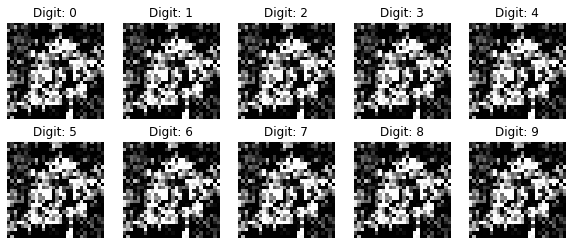

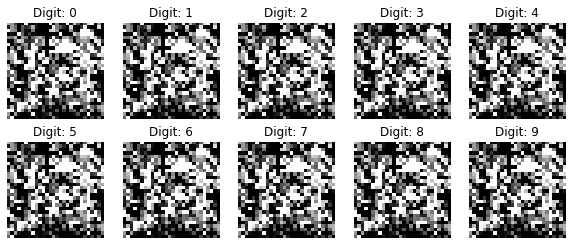

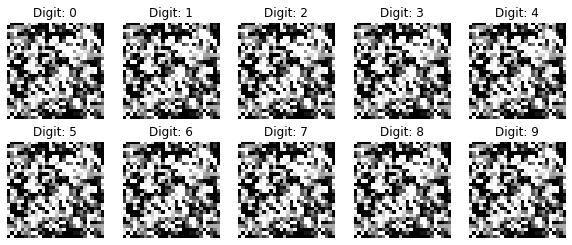

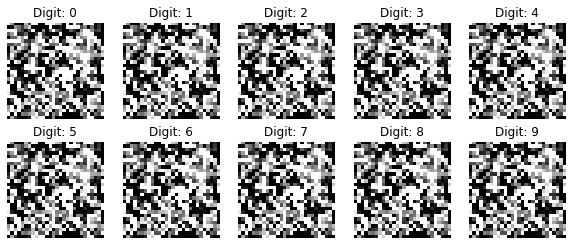

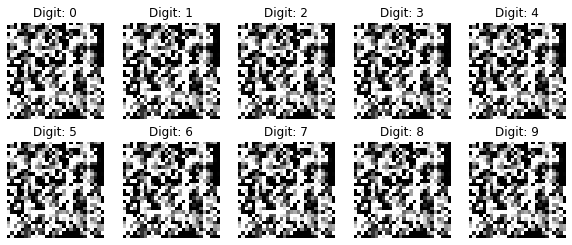

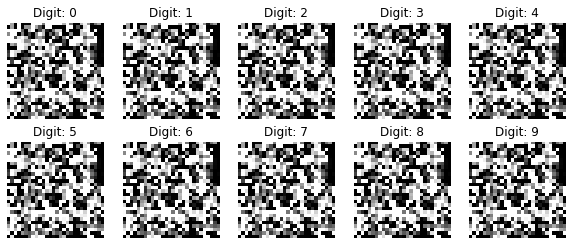

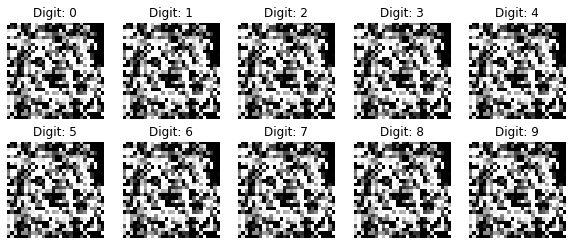

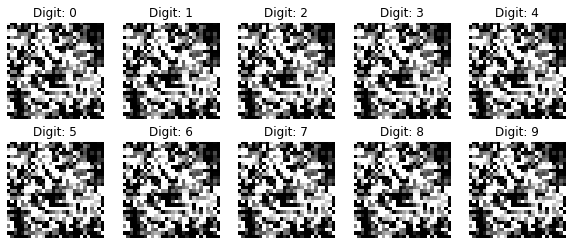

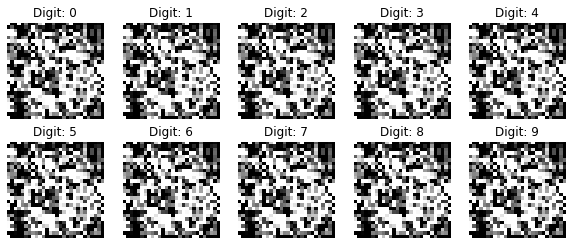

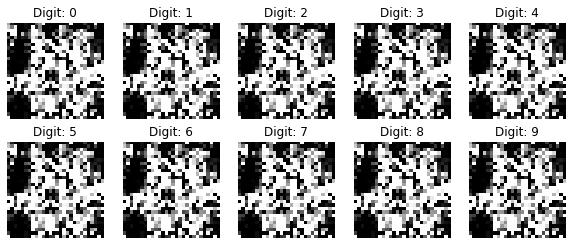

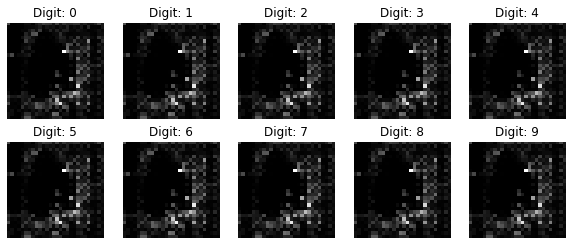

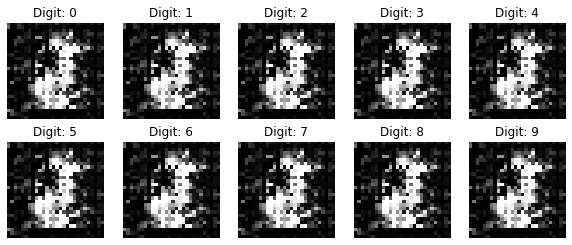

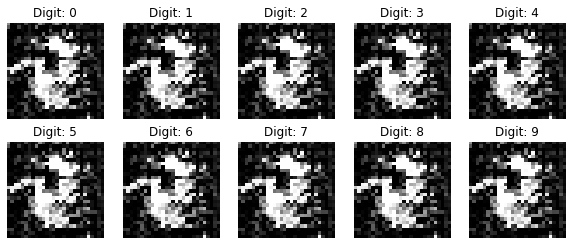

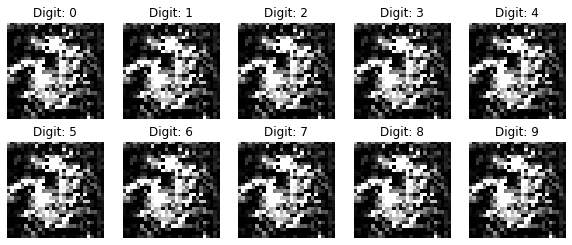

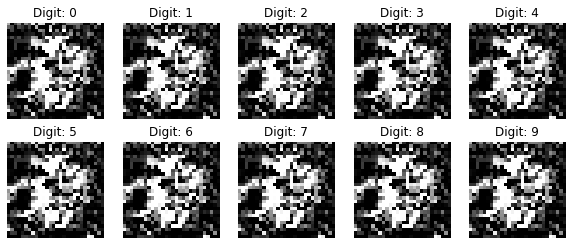

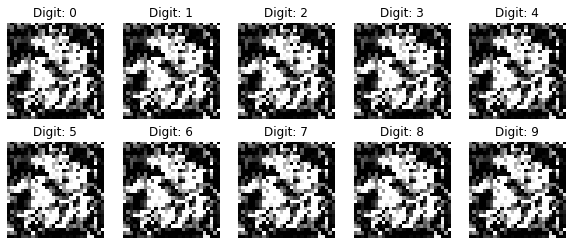

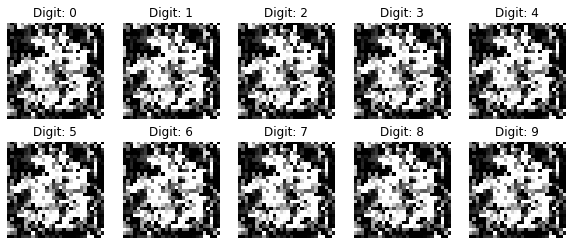

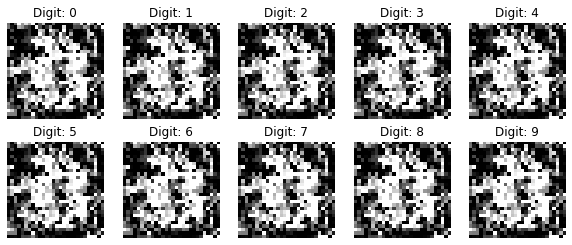

In [6]:
iterations = 20000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)

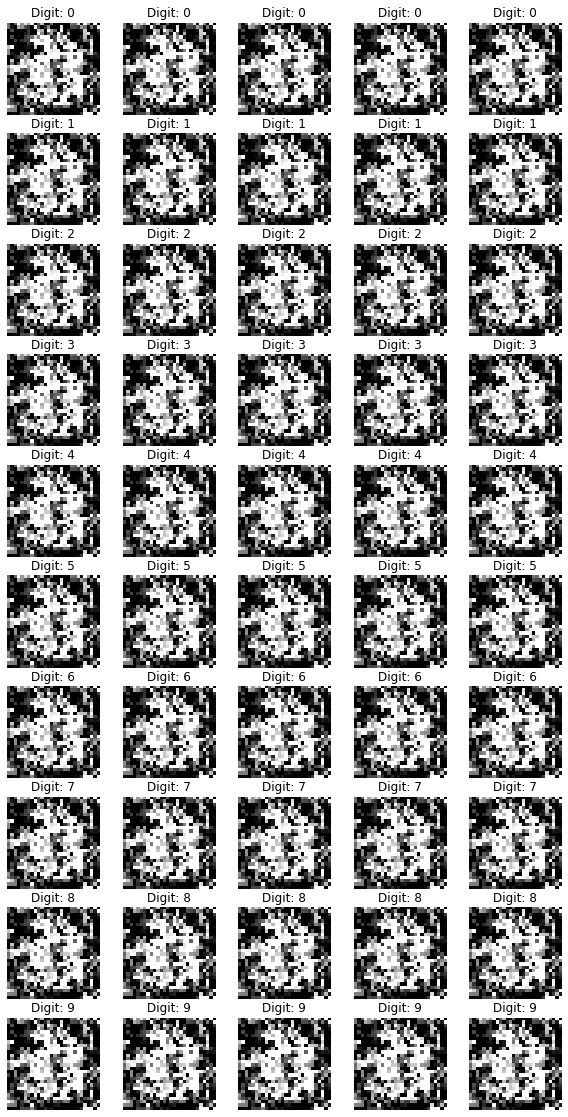

In [7]:
# 훈련이 다 된 CGAN 모델의 출력 검증

image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1